In [2]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

import numpy as np

In [3]:

def plot_inertia(
    df,
    partionning_space="true_proba_error",
    n_samples_train=None,
    n_samples_test=None,
    cluster_value=None,
    seed_test=None,
):
    """
    Two‐panel plot: 
    – Left:  FPR_train vs Inertia
    – Right: FPR_val   vs Inertia

    On each panel we plot all seeds’ scatter and overlay
    a single overall least‐squares line. Legends are removed.
    """
    # filter once
    df_c = df[
        (df['n_clusters'] == cluster_value) &
        (df['n_samples_train'] == n_samples_train) &
        df['inertia'].notnull() &
        df['fpr_train'].notnull() &
        df['fpr_val'].notnull() &
        (df['seed_test'] == seed_test) &
        (df["n_samples_test"] == n_samples_test) &
        (df['method'] == "kmeans") &
        (df["partionning_space"] == partionning_space)
    ]
    print(df_c)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
    y_cols = ['fpr_train', 'fpr_val']
    y_labels = ['FPR (train)', 'FPR (validation)']

    # for each subplot
    for ax, y_col, y_lab in zip(axes, y_cols, y_labels):
        # scatter per‐seed
        for seed in sorted(df_c['kmeans_seed'].unique()):
            sub = df_c[df_c['kmeans_seed'] == seed].sort_values('inertia')
            ax.plot(
                sub['inertia'],
                sub[y_col],
                marker='o',
                linestyle='',
                alpha=0.5
            )

        # overall LS fit
        x_all = df_c['inertia'].values
        y_all = df_c[y_col].values
        if len(x_all) >= 2:
            m, b = np.polyfit(x_all, y_all, 1)
            x_fit = np.linspace(x_all.min(), x_all.max(), 100)
            ax.plot(
                x_fit,
                m * x_fit + b,
                linestyle='-',
                linewidth=2,
                color='black'
            )

        ax.set_xlabel('Inertia')
        ax.set_ylabel(y_lab)
        ax.grid(True)

    fig.suptitle(f'n_clusters={cluster_value}, n_samples_train={n_samples_train}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    plt.close()



def plot_experiment_histograms(experiment_dfs,
                               score_col='val_detector_preds',
                               label_col='val_detector_labels',
                               labels=('No error', 'Error'),
                               bins=60):
    """
    Plots normalized-frequency histograms of `score_col` for label=False vs label=True
    for each experiment DataFrame in `experiment_dfs`.

    Parameters
    ----------
    experiment_dfs : dict[str, pd.DataFrame]
        Mapping from experiment name to its predictions DataFrame.
    score_col : str
        Column name of the score/prediction.
    label_col : str
        Column name of the boolean true label.
    labels : tuple[str, str]
        (label for False, label for True)
    bins : int
        Number of histogram bins.
    """
    n = len(experiment_dfs)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 5), sharey=True)
    if n == 1:
        axes = [axes]

    for ax, (exp_name, df) in zip(axes, experiment_dfs.items()):
        # compute common bin edges
        all_scores = df[score_col]
        bin_edges = np.linspace(all_scores.min(), all_scores.max(), bins)

        # split scores by label
        scores_0 = df.loc[~df[label_col], score_col]
        scores_1 = df.loc[df[label_col],  score_col]

        # plot
        ax.hist(scores_0, bins=bin_edges, density=True, alpha=0.5, label=labels[0])
        ax.hist(scores_1, bins=bin_edges, density=True, alpha=0.5, label=labels[1])

        ax.set_title(exp_name)
        ax.set_xlabel('Detecttion Score')
        if ax is axes[0]:
            ax.set_ylabel('Normalized Frequency')
        ax.legend(title='True Label')
        ax.grid(True)

    plt.tight_layout()
    plt.show()

def plot_fpr_2(
    df,
    method="uniform",
    partionning_space="gini",
    cluster_values=None,
    seed_test=None,
    n_samples_train_inf=None,
    n_samples_train_sup=None,
    ylim=None,  # new argument: e.g. (0.0, 0.1)
):
    # ---- SETUP FIGURE ----
    n_values = len(cluster_values)
    fig, axes = plt.subplots(1, n_values, figsize=(14, 5), sharey=True)
    fig.suptitle(f"{method} partition on {partionning_space}")
    if n_values == 1:
        axes = [axes]
    for ax, cluster_value in zip(axes, cluster_values):
        # 1) Filter for this cluster
        df_c = df[
            (df['n_clusters'] == cluster_value) &
            (df['n_samples_train'] >= n_samples_train_inf) &
            (df['n_samples_train'] <= n_samples_train_sup) &
            df['fpr_val'].notnull() &
            (df['seed_test'] == seed_test) &
            (df['method'] == method) &
            (df['partionning_space'] == partionning_space)
        ]
        # 2) Scatter/line for each seed_train
        for seed_train in sorted(df_c['seed_train'].unique()):
            df_s = df_c[df_c['seed_train'] == seed_train].sort_values('n_samples_train')
            ax.plot(
                df_s['n_samples_train'],
                df_s['fpr_val'],
                marker='o',
                linestyle='-',
                alpha=0.6,
                label=f"seed {seed_train}"
            )
        
        # 3) Compute mean & std at each n_samples_train
        stats = (
            df_c
            .groupby('n_samples_train')['fpr_val']
            .agg(['mean', 'std'])
            .reset_index()
        )
        # ax.hlines(gini_experiment["fpr_val"].item(), xmin=n_samples_train_inf, xmax=n_samples_train_sup,
        #         color="red", linestyle="--", label="Gini Detector FPR")
        # 4) Plot mean line
        ax.plot(
            stats['n_samples_train'],
            stats['mean'],
            color='black',
            linewidth=2,
            label='Mean'
        )
        # 5) Shade ±1 STD
        ax.fill_between(
            stats['n_samples_train'],
            stats['mean'] - stats['std'],
            stats['mean'] + stats['std'],
            color='gray',
            alpha=0.3,
            label='±1 STD'
        )
        
        # 6) Decorations
        ax.set_title(f'n_clusters = {cluster_value}')
        ax.set_xlabel('n_samples_train')
        if ax is axes[0]:
            ax.set_ylabel('FPR (validation)')
        ax.grid(True)
        ax.set_xlim(n_samples_train_inf, n_samples_train_sup)
        
        # 7) Apply y-axis limits if provided
        if ylim is not None:
            ax.set_ylim(ylim)
        
        ax.legend(title='Seed_train', bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.tight_layout()
    plt.show()
    plt.close()

def plot_fpr_method_comparison(
    df,
    cluster_values,
    seed_test,
    n_samples_train_inf,
    n_samples_train_sup,
    ylim=None,  # e.g. (0.0, 0.1)
):
    """
    Plots FPR curves for two methods ("uniform" vs "kmeans") across different numbers of clusters.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns ['n_clusters','n_samples_train','fpr_val','seed_test','seed_train','method'].
    cluster_values : list of int
        The distinct n_clusters to plot (one row per cluster).
    seed_test : int
        The seed_test value to filter for.
    n_samples_train_inf : int
        Minimum n_samples_train to include.
    n_samples_train_sup : int
        Maximum n_samples_train to include.
    ylim : tuple or None
        y‐axis limits (min, max); if None, auto‐scaled.
    """
    methods = ["uniform", "kmeans"]
    n_values = len(cluster_values)
    
    fig, axes = plt.subplots(
        nrows=n_values,
        ncols=2,
        figsize=(14, 5 * n_values),
        sharey=True
    )
    
    # Add column headers
    for j, method in enumerate(methods):
        axes[0, j].set_title(f"{method.capitalize()} method", fontsize=14, pad=20)
    
    for i, cluster_value in enumerate(cluster_values):
        for j, method in enumerate(methods):
            ax = axes[i, j]
            
            # 1) Filter for cluster & method
            df_c = df[
                (df["n_clusters"] == cluster_value) &
                (df["n_samples_train"] >= n_samples_train_inf) &
                (df["n_samples_train"] <= n_samples_train_sup) &
                df["fpr_val"].notnull() &
                (df["seed_test"] == seed_test) &
                (df["method"] == method) &
            (df["partionning_space"].isna())
            ]
            
            # 2) Plot each seed_train
            for seed_train in sorted(df_c["seed_train"].unique()):
                df_s = df_c[df_c["seed_train"] == seed_train].sort_values("n_samples_train")
                ax.plot(
                    df_s["n_samples_train"],
                    df_s["fpr_val"],
                    marker="o",
                    linestyle="-",
                    alpha=0.6,
                    label=f"seed {seed_train}"
                )
            
            # 3) Compute mean & std at each n_samples_train
            stats = (
                df_c
                .groupby("n_samples_train")["fpr_val"]
                .agg(["mean", "std"])
                .reset_index()
            )
            
            # 4) Plot mean line
            ax.plot(
                stats["n_samples_train"],
                stats["mean"],
                color="black",
                linewidth=2,
                label="Mean"
            )
            
            # 5) Shade ±1 STD
            ax.fill_between(
                stats["n_samples_train"],
                stats["mean"] - stats["std"],
                stats["mean"] + stats["std"],
                color="gray",
                alpha=0.3,
                label="±1 STD"
            )
            ax.hlines(
                bayes_experiment["fpr_val"].item(),
                xmin=n_samples_train_inf,
                xmax=n_samples_train_sup,
                color="red",
                linestyle="--",
                label="Bayes Detector FPR"
        )
            # 6) Decorations
            ax.set_xlabel("n_samples_train")
            if j == 0:
                ax.set_ylabel("FPR (validation)")
            ax.set_xlim(n_samples_train_inf, n_samples_train_sup)
            if ylim is not None:
                ax.set_ylim(ylim)
            ax.grid(True)
            ax.legend(title="Seed_train", bbox_to_anchor=(1.02, 1), loc="upper left")
            
            # 7) Row title on leftmost plots
            if j == 0:
                ax.text(
                    -0.2, 0.5,
                    f"n_clusters = {cluster_value}",
                    transform=ax.transAxes,
                    rotation=90,
                    va="center",
                    fontsize=12
                )
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    


def plot_fpr(
    df,
    method="uniform",
    cluster_values=None,
    seed_test=None,
    n_samples_train_inf=None,
    n_samples_train_sup=None,
    ylim=None,  # new argument: e.g. (0.0, 0.1)
):
    """
    Plots FPR curves for each seed_train across different n_clusters,
    then adds one shared legend without duplicate entries.
    """
    # ---- SETUP FIGURE ----
    n_values = len(cluster_values)
    fig, axes = plt.subplots(1, n_values, figsize=(14, 5), sharey=True)
    if n_values == 1:
        axes = [axes]
    fig.suptitle(f"Method: {method}")

    for ax, cluster_value in zip(axes, cluster_values):
        # 1) Filter for this cluster
        df_c = df[
            (df['n_clusters'] == cluster_value) &
            (df['n_samples_train'] >= n_samples_train_inf) &
            (df['n_samples_train'] <= n_samples_train_sup) &
            df['fpr_val'].notnull() &
            (df['seed_test'] == seed_test) &
            (df['method'] == method) &
            (df["partionning_space"].isna())
        ]

        # 2) Scatter/line for each seed_train
        for seed_train in sorted(df_c['seed_train'].unique()):
            df_s = df_c[df_c['seed_train'] == seed_train].sort_values('n_samples_train')
            ax.plot(
                df_s['n_samples_train'],
                df_s['fpr_val'],
                marker='o',
                linestyle='-',
                alpha=0.6,
                label=f"seed {seed_train}"
            )

        # 3) Compute mean & std at each n_samples_train
        stats = (
            df_c
            .groupby('n_samples_train')['fpr_val']
            .agg(['mean', 'std'])
            .reset_index()
        )

        # 4) Reference line for Bayes Detector FPR
        ax.hlines(
            bayes_experiment["fpr_val"].item(),
            xmin=n_samples_train_inf,
            xmax=n_samples_train_sup,
            color="red",
            linestyle="--",
            label="Bayes Detector FPR"
        )

        # 5) Plot mean line
        ax.plot(
            stats['n_samples_train'],
            stats['mean'],
            color='black',
            linewidth=2,
            label='Mean'
        )

        # 6) Shade ±1 STD
        ax.fill_between(
            stats['n_samples_train'],
            stats['mean'] - stats['std'],
            stats['mean'] + stats['std'],
            color='gray',
            alpha=0.3,
            label='±1 STD'
        )

        # 7) Decorations
        ax.set_title(f'n_clusters = {cluster_value}')
        ax.set_xlabel('n_samples_train')
        if ax is axes[0]:
            ax.set_ylabel('FPR (validation)')
        ax.grid(True)
        ax.set_xlim(n_samples_train_inf, n_samples_train_sup)
        if ylim is not None:
            ax.set_ylim(ylim)

    # ——— AFTER THE LOOP: SHARED LEGEND WITHOUT DUPLICATES ———
    # 1) Collect all handles & labels
    all_handles = []
    all_labels = []
    for ax in axes:
        handles, labels = ax.get_legend_handles_labels()
        all_handles.extend(handles)
        all_labels.extend(labels)

    # 2) Remove duplicate labels (preserve order)
    unique = {}
    for h, l in zip(all_handles, all_labels):
        if l not in unique:
            unique[l] = h
    unique_labels = list(unique.keys())
    unique_handles = [unique[l] for l in unique_labels]

    # 3) Add a single legend to the figure
    fig.legend(
        unique_handles,
        unique_labels,
        title="Series",
        loc="upper right",
        bbox_to_anchor=(1.15, 0.9)
    )

    # 4) Make room and finalize
    plt.subplots_adjust(right=0.82)
    plt.tight_layout()
    plt.show()
    plt.close()


def collect_experiment_comparison_data(results_dir):
    """
    Scans the results/experiments directory, reads each experiment folder,
    and collects all configuration parameters along with the mean and std for 
    each accuracy metric (fpr, auc, aurc) from train and test CSV files.
    
    For fpr, the mean is computed as before. The standard deviation for fpr is computed as:
      - If all folds provided a var_fpr value: new_std = sqrt(sum(var_fpr) / (n_fold^2))
      - Otherwise: new_std = standard deviation of the fpr values.
    For auc and aurc, mean and std are computed in the standard way.
    
    Args:
        results_dir (str): Base directory containing the experiments folder.
        
    Returns:
        DataFrame: DataFrame where each row corresponds to an experiment and 
                   columns include all configuration parameters and the computed metrics.
    """
    experiment_dirs = [
        os.path.join(results_dir, d)
        for d in os.listdir(results_dir)
        if os.path.isdir(os.path.join(results_dir, d)) and d.startswith("experiment_")
    ]
    
    records = []
    
    for exp_dir in tqdm(experiment_dirs, desc="Processing experiment directories"):
        record = {}
        config_path = os.path.join(exp_dir, "config.json")
        if not os.path.exists(config_path):
            print(f"Config file not found in {exp_dir}. Skipping...")
            continue
        
        with open(config_path, "r") as f:
            config = json.load(f)
        record.update(config)
        
                
        # Process test fold CSVs.
        results_path = os.path.join(exp_dir, "detector_results.csv")
        if not os.path.exists(results_path):
            print(f"Results file not found in {results_path}. Skipping...")
            continue
        df = pd.read_csv(results_path)
        row = df.iloc[0]
        record.update(row.to_dict())
  
        
        records.append(record)
    
    if not records:
        print("No experiment records found.")
        return None
    
    df = pd.DataFrame(records)
    if "fpr" in df.columns:
        df.sort_values(by="fpr", inplace=True, na_position="last")
    return df

In [4]:
RESULTS_DIR = "../../synth_results/asymp_exp"


df = collect_experiment_comparison_data(RESULTS_DIR)
if df is None or df.empty:
    print("No data to write to CSV.")
df.head()

Processing experiment directories:   0%|          | 0/4819 [00:00<?, ?it/s]

Processing experiment directories:   1%|▏         | 63/4819 [00:00<00:15, 314.15it/s]

Results file not found in ../../synth_results/asymp_exp/experiment_127/detector_results.csv. Skipping...


Processing experiment directories:  17%|█▋        | 804/4819 [00:03<00:20, 193.76it/s]

Results file not found in ../../synth_results/asymp_exp/experiment_4249/detector_results.csv. Skipping...


Processing experiment directories:  24%|██▍       | 1159/4819 [00:05<00:17, 212.18it/s]

Results file not found in ../../synth_results/asymp_exp/experiment_101/detector_results.csv. Skipping...


Processing experiment directories:  41%|████▏     | 1996/4819 [00:09<00:12, 219.63it/s]

Results file not found in ../../synth_results/asymp_exp/experiment_1576/detector_results.csv. Skipping...


Processing experiment directories:  51%|█████     | 2439/4819 [00:11<00:12, 183.11it/s]

Results file not found in ../../synth_results/asymp_exp/experiment_43/detector_results.csv. Skipping...


Processing experiment directories: 100%|██████████| 4819/4819 [00:23<00:00, 207.36it/s]


,n_samples_train,n_samples_test,batch_size_train,batch_size_test,n_clusters,method,seed_train,seed_test,experiment_datetime,fpr_train,...,tpr_val,thr_val,kmeans_seed,init_scheme,inertia,partionning_space,experiment_folder,temperature,normalize,normalize_gini
0,77000,100000,100000,100000,500.0,uniform,3,-1,2025-04-17_19-07-19,0.166798,...,0.950825,0.127240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,84000,100000,100000,100000,50.0,kmeans,1,-1,2025-04-18_00-52-22,0.165898,...,0.957170,0.079339,0.0,k-means++,0.598178,NaN,NaN,NaN,NaN,NaN
2,27000,100000,100000,100000,5.0,kmeans,2,-1,2025-04-17_23-32-59,1.000000,...,1.000000,0.015322,0.0,k-means++,21.761238,NaN,NaN,NaN,NaN,NaN
3,45000,100000,100000,100000,50.0,kmeans,4,-1,2025-04-18_00-38-30,0.165133,...,0.957011,0.092667,0.0,k-means++,0.296487,NaN,NaN,NaN,NaN,NaN
4,6500,100000,100000,100000,20.0,uniform,1,-1,2025-04-18_10-04-45,0.149388,...,1.000000,0.022226,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Variance of FPR w.r.t. $D_{\mathbb{train}}$**

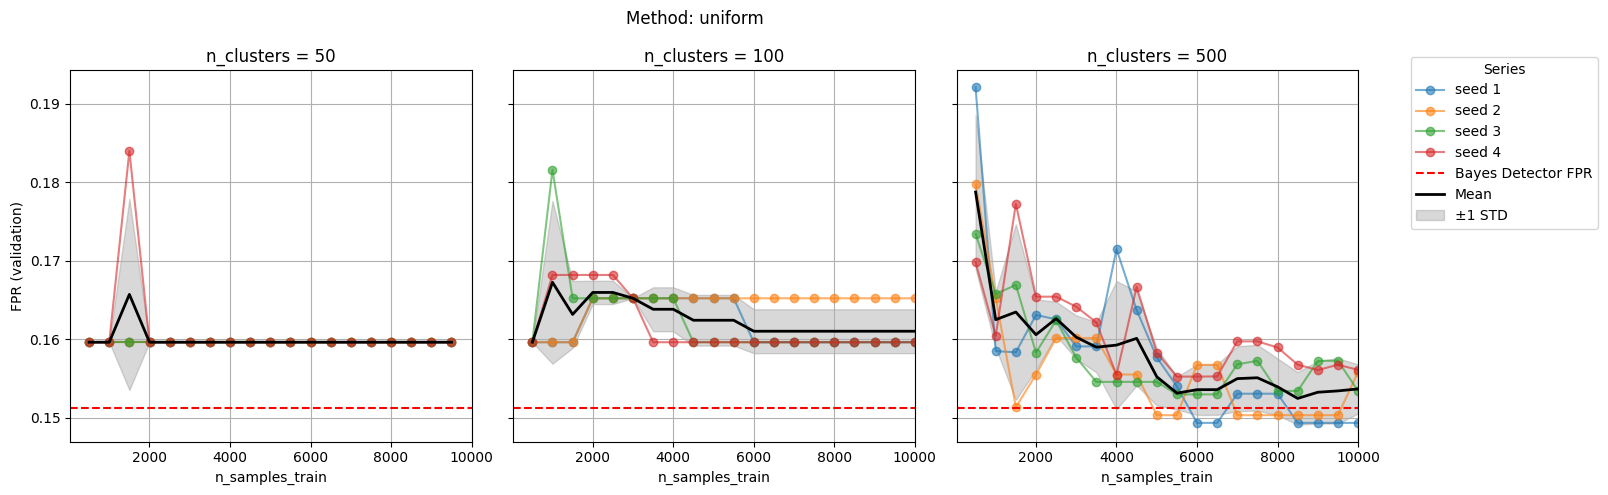

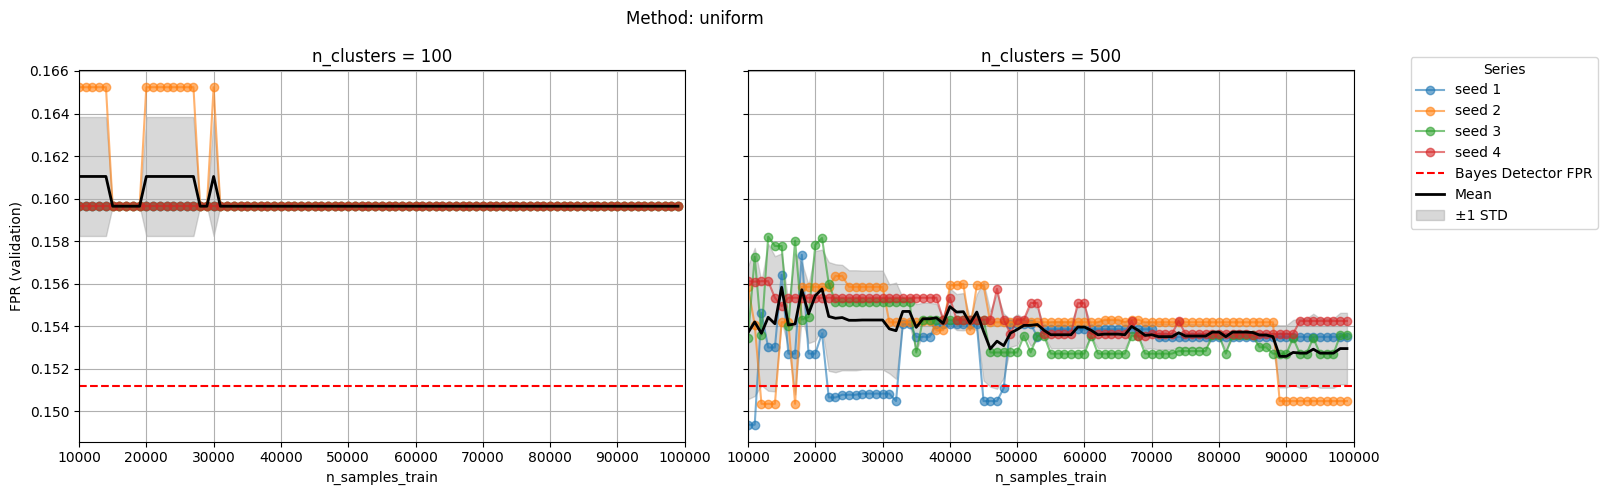

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---- PARAMETERS ----
cluster_values      = [50, 100, 500]    # the two n_clusters values you care about
n_samples_train_inf = 30
n_samples_train_sup = 10000
seed_test           = -1
 

plot_fpr(df, cluster_values=cluster_values, seed_test=seed_test, n_samples_train_inf = n_samples_train_inf, n_samples_train_sup = 10000)
plot_fpr(df, seed_test=seed_test, cluster_values = [100, 500], n_samples_train_inf = 10000, n_samples_train_sup = 100000)


**Uniform partionning vs Kmeans**

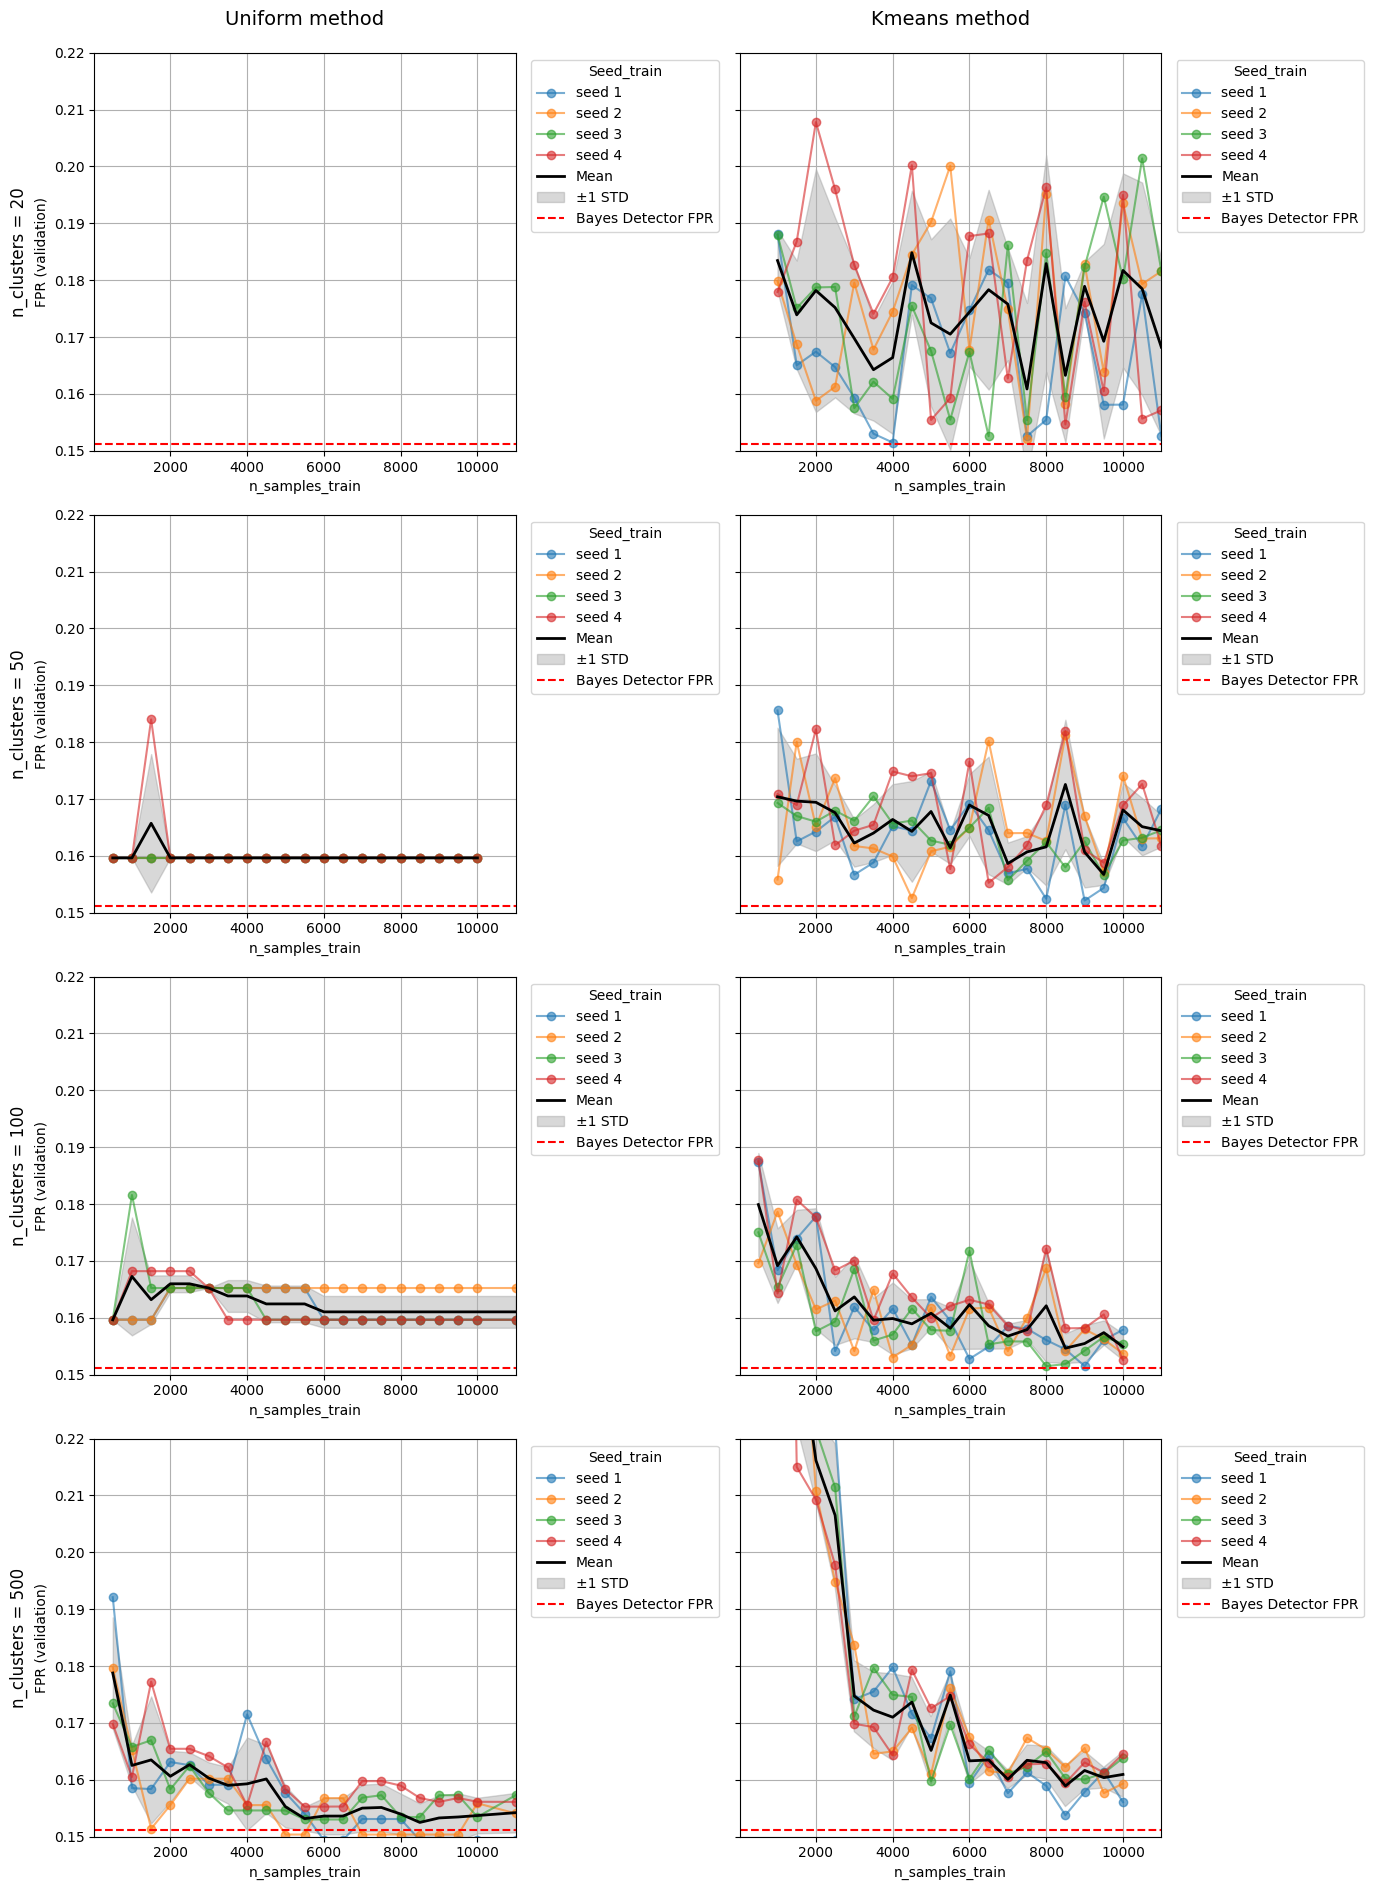

In [178]:

n_samples_train_inf = 20
n_samples_train_sup = 11000
ylim = (0.15, 0.22)
seed_test = -1
plot_fpr_method_comparison(df, cluster_values=[20, 50, 100, 500], seed_test=seed_test,
          n_samples_train_inf = n_samples_train_inf, n_samples_train_sup = n_samples_train_sup,
          ylim=ylim)

**Kmeans works with n_cluster = 10 !!**

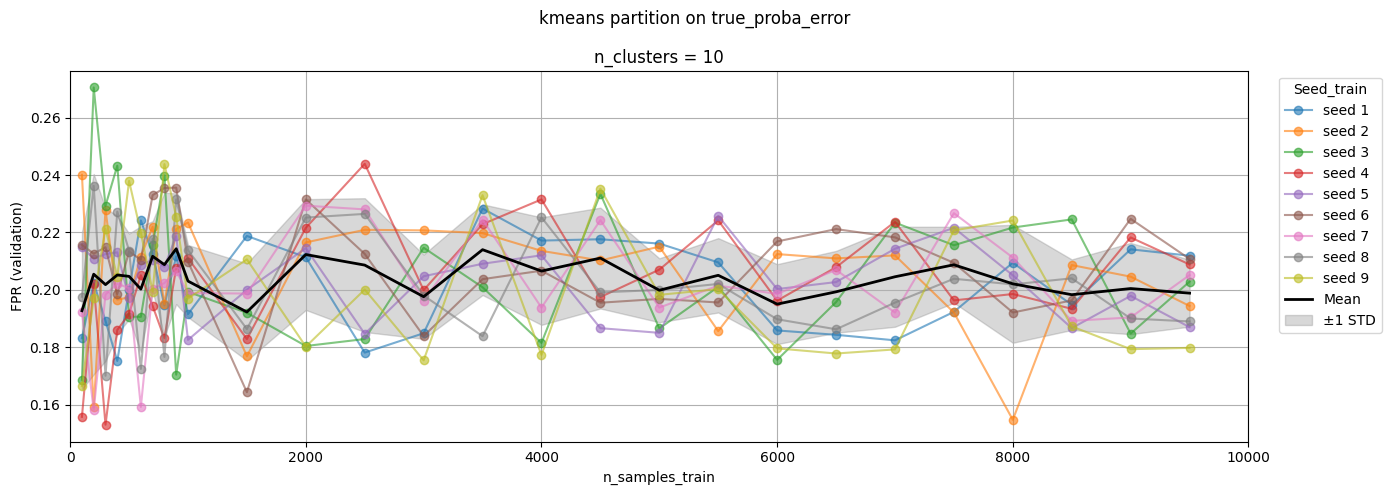

In [191]:
plot_fpr_2(
    df,
    method="kmeans",
    partionning_space="true_proba_error",
    cluster_values = [10],
    n_samples_train_inf=0,
    n_samples_train_sup=10000,
    seed_test=-1)

**Is Inertia of Kmeans Correlated to FPR ?**

      n_samples_train  n_samples_test  batch_size_train  batch_size_test  \
431             10000         1000000            100000           100000   
514             10000         1000000            100000           100000   
707             10000         1000000            100000           100000   
731             10000         1000000            100000           100000   
1252            10000         1000000            100000           100000   
1266            10000         1000000            100000           100000   
1367            10000         1000000            100000           100000   
1518            10000         1000000            100000           100000   
1680            10000         1000000            100000           100000   
1703            10000         1000000            100000           100000   
1891            10000         1000000            100000           100000   
1941            10000         1000000            100000           100000   
1974        

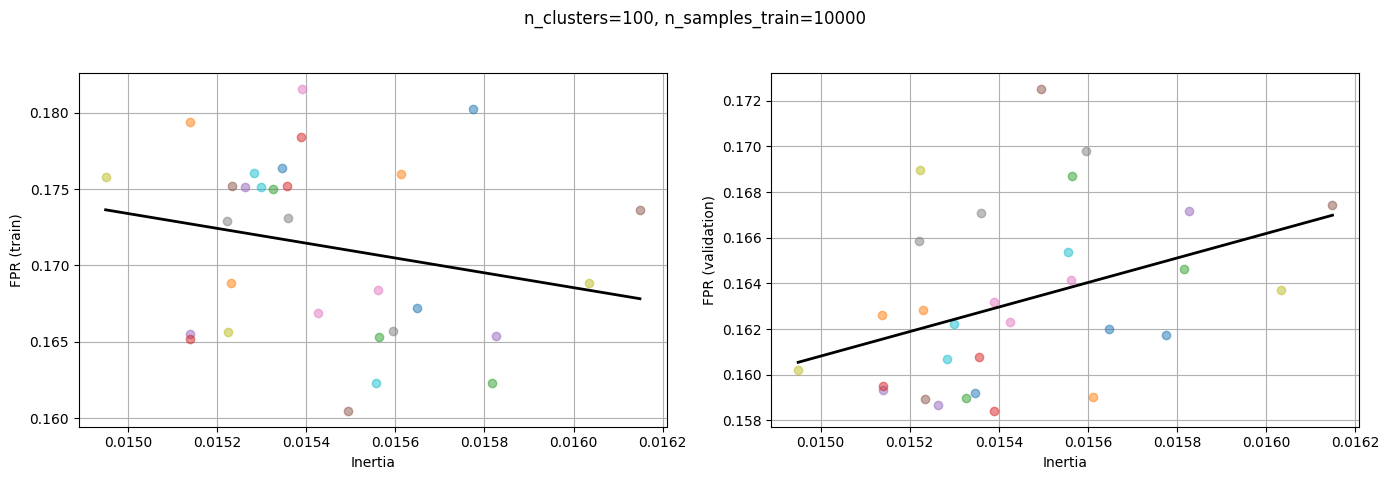

In [9]:
plot_inertia(
    df,
    partionning_space="true_proba_error",
    n_samples_train=10000,
    n_samples_test = 1000000,
    cluster_value=100,
    seed_test=-2,
)

**How Kmeans build its partition ?**

In [5]:
import math
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_experiment_histograms_(df, n_samples_train, n_samples_test, n_clusters, method,
                                seed_train, seed_test, partionning_space,
                                score_col='embs',
                                label_col='detector_labels',
                                labels=('No error', 'Error'),
                                bins=60):
    """
    Plots normalized-frequency histograms of `score_col` for label=False vs label=True
    for each experiment DataFrame in `experiment_dfs`, arranged in 2 columns.
    Each subplot is titled with its kmeans_seed.
    """
    # filter the master df
    df_c = df[(df["n_samples_train"] == n_samples_train) &
              (df["n_samples_test"] == n_samples_test) &
              (df["n_clusters"] == n_clusters) &
              (df["method"] == method) &
              (df["seed_train"] == seed_train) &
              (df["seed_test"] == seed_test) &
              (df["partionning_space"] == partionning_space)]

    experiment_nbs = df_c["experiment_folder"].to_list()
    kmeans_seeds = df_c["kmeans_seed"].to_list()

    n = len(experiment_nbs)

    if n == 0:
        print("No experiments matched the given parameters.")
        return

    # compute grid size: 2 columns, rows = ceil(n/2)
    n_cols = 2
    n_rows = math.ceil(n / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), sharey=True)
    axes = axes.flatten()

    for idx, (ax, exp_nb, seed_k) in enumerate(zip(axes, experiment_nbs, kmeans_seeds)):
        
        # load cluster centers and training predictions
        centers = pd.read_csv(
            os.path.join(RESULTS_DIR, exp_nb, "cluster_centers.csv")
        )
        centers = centers["centers"].values
        exp_train_predictions = pd.read_csv(
            os.path.join(RESULTS_DIR, exp_nb, "detector_train_predictions.csv")
        )

        # define common bins
        all_scores = exp_train_predictions[score_col]
        bin_edges = np.linspace(all_scores.min(), all_scores.max(), bins)

        # split scores by true label
        scores_0 = exp_train_predictions.loc[~exp_train_predictions[label_col], score_col]
        scores_1 = exp_train_predictions.loc[exp_train_predictions[label_col], score_col]

        # plot histograms
        ax.hist(scores_0, bins=bin_edges, density=True, alpha=0.5, label=labels[0])
        ax.hist(scores_1, bins=bin_edges, density=True, alpha=0.5, label=labels[1])

        # add cluster boundaries
        mid_boundaries = (centers[:-1] + centers[1:]) / 2.0
        boundaries = np.concatenate(([0.0], mid_boundaries, [1.0]))
        for b in boundaries:
            ax.axvline(b, color='k', linestyle='--', linewidth=1.2)

        # title with kmeans_seed
        fpr_val = df_c[df_c["experiment_folder"] == exp_nb]["fpr_val"].item()
        ax.set_title(f'kmeans_seed = {seed_k} - FPR = {fpr_val:.3f}')
        ax.set_xlabel('Detection Score')
        if idx % n_cols == 0:
            ax.set_ylabel('Normalized Frequency')
        ax.legend(title='True Label')
        ax.grid(True)

    # turn off unused subplots
    for j in range(n, len(axes)):
        fig.delaxes(axes[j])
    fig.suptitle(f'n_clusters={n_clusters}, n_samples_train={n_samples_train}')
    plt.tight_layout()
    plt.show()




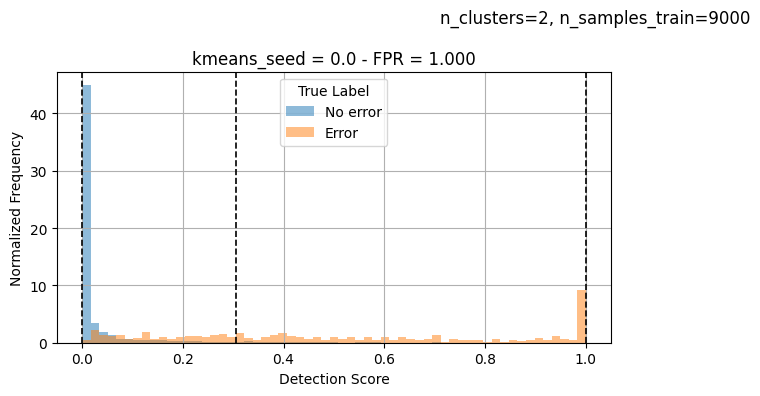

In [9]:
plot_experiment_histograms_(
    df,
    n_samples_train=9000,
    n_samples_test=100000,
    n_clusters=2,
    method="kmeans",
    seed_train=4,
    seed_test=-1,
    partionning_space="true_proba_error"
)


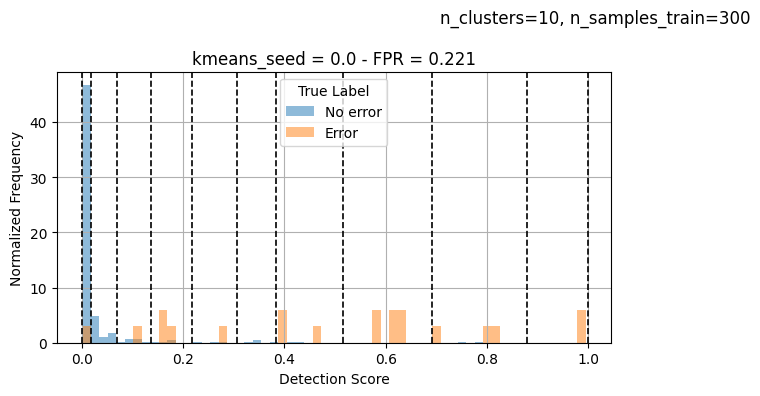

In [202]:
plot_experiment_histograms_(
    df,
    n_samples_train=300,
    n_samples_test=100000,
    n_clusters=10,
    method="kmeans",
    seed_train=9,
    seed_test=-1,
    partionning_space="true_proba_error"
)


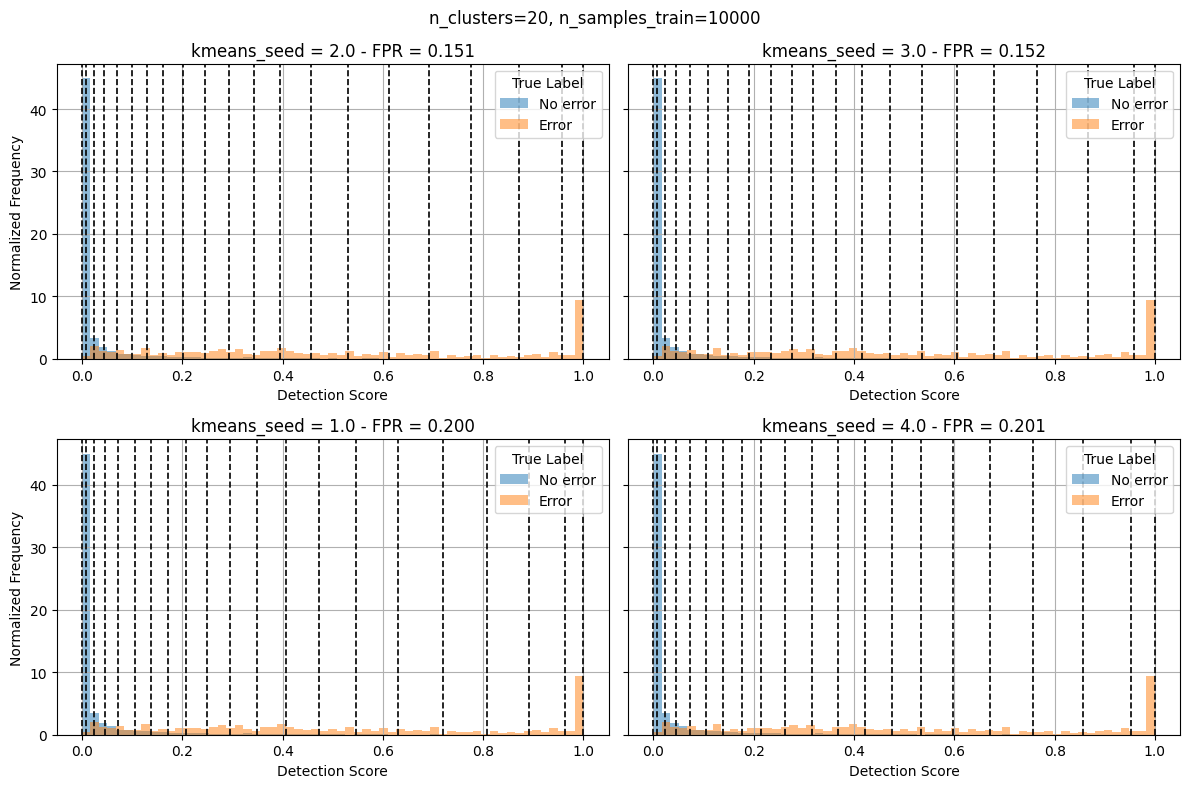

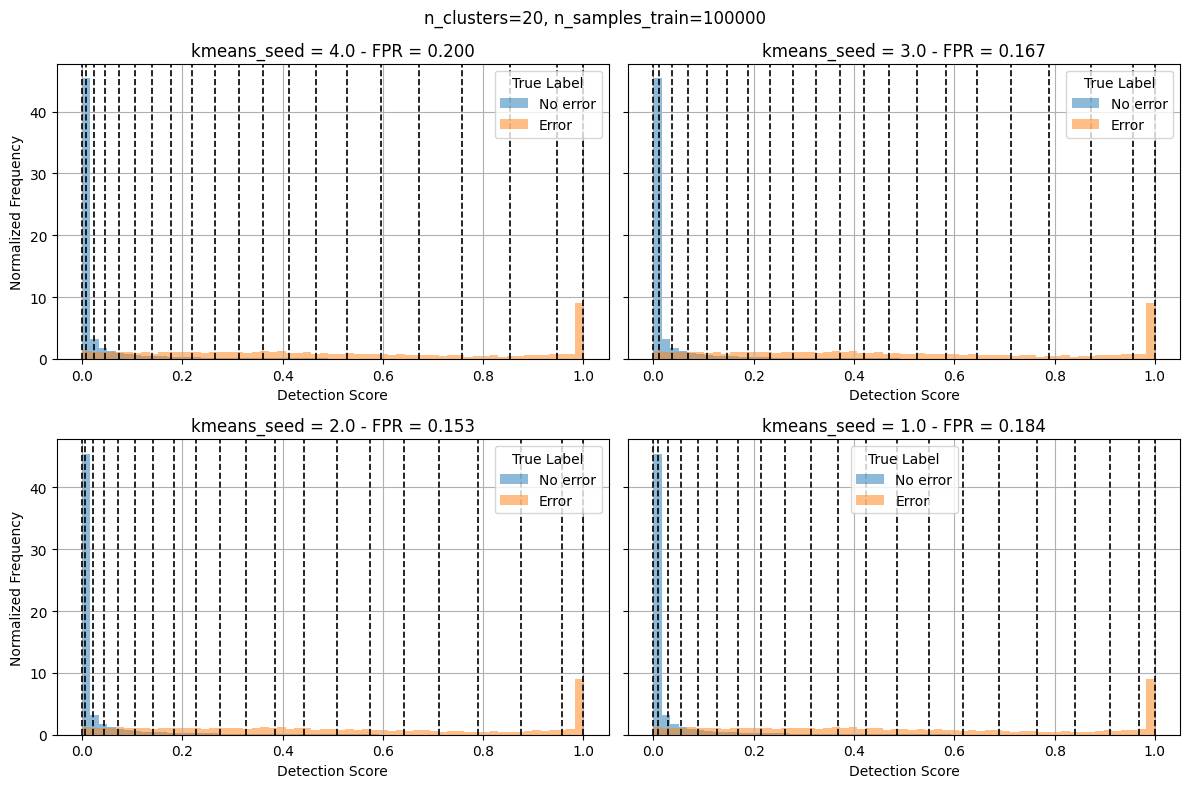

In [194]:
plot_experiment_histograms_(
    df,
    n_samples_train=10000,
    n_samples_test=100000,
    n_clusters=20,
    method="kmeans",
    seed_train=4,
    seed_test=-1,
    partionning_space="true_proba_error"
)

plot_experiment_histograms_(
    df,
    n_samples_train=100000,
    n_samples_test=100000,
    n_clusters=20,
    method="kmeans",
    seed_train=4,
    seed_test=-1,
    partionning_space="true_proba_error"
)

**We now suppose that we don't have access to the true probability of error $$ \eta(x) = \mathbb{P}\{ f(x) \neq Y \}.$$**
**Insted, we approximate it with the gini index**
$$\mathrm{gini}(x) = 1 - \sum_{y \in \mathcal{Y}} P^2_{\hat{Y} \mid X}(y \mid x)$$

**Q1: Is $\mathrm{gini}(x)$ a good approximation of $\eta(x)$ ?**

In [203]:
temperature = 1
normalize_gini = False
seed_test = -1
gini_experiment = df[
    (df["method"] == "gini") & 
    (df["temperature"] == temperature) & 
    (df["normalize_gini"] == normalize_gini) &
    (df["seed_test"] == seed_test) 
]
bayes_experiment = df[
    (df["method"] == "bayes") &
    (df["seed_test"] == seed_test) 
]
print("Gini Detector FPR:", gini_experiment["fpr_val"].item())
print("Bayes Detector FPR:", bayes_experiment["fpr_val"].item())


Gini Detector FPR: 0.2999060792349727
Bayes Detector FPR: 0.151212431693989


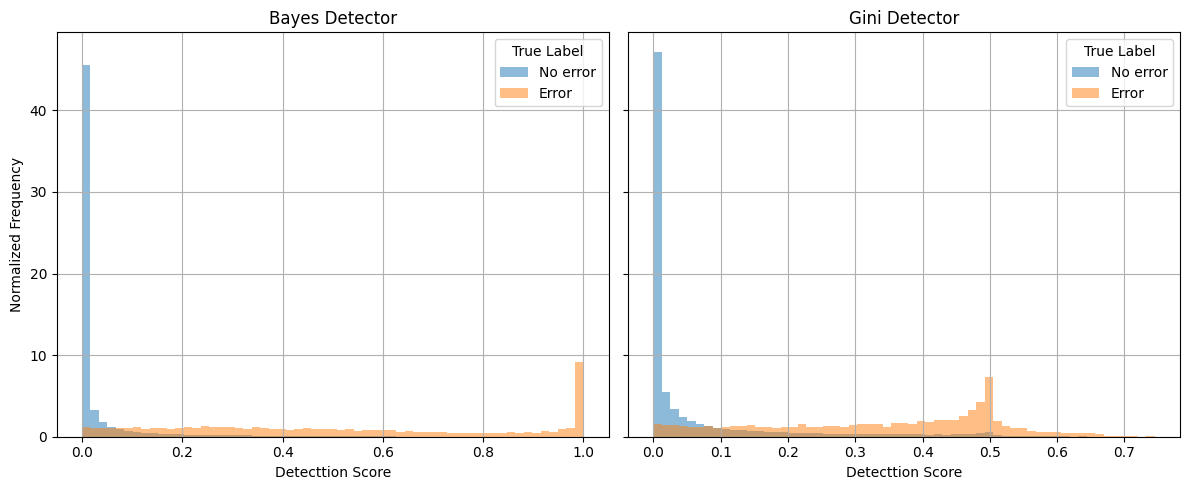

In [205]:
gini_experiment_nb = gini_experiment["experiment_folder"].item()
gini_predictions = pd.read_csv(os.path.join(RESULTS_DIR, gini_experiment_nb,"detector_predictions.csv"))


bayes_experiment_dir = bayes_experiment["experiment_folder"].item()
bayes_predictions = pd.read_csv(os.path.join(RESULTS_DIR, bayes_experiment_dir,"detector_predictions.csv"))

plot_experiment_histograms({"Bayes Detector" :bayes_predictions, "Gini Detector" :gini_predictions})

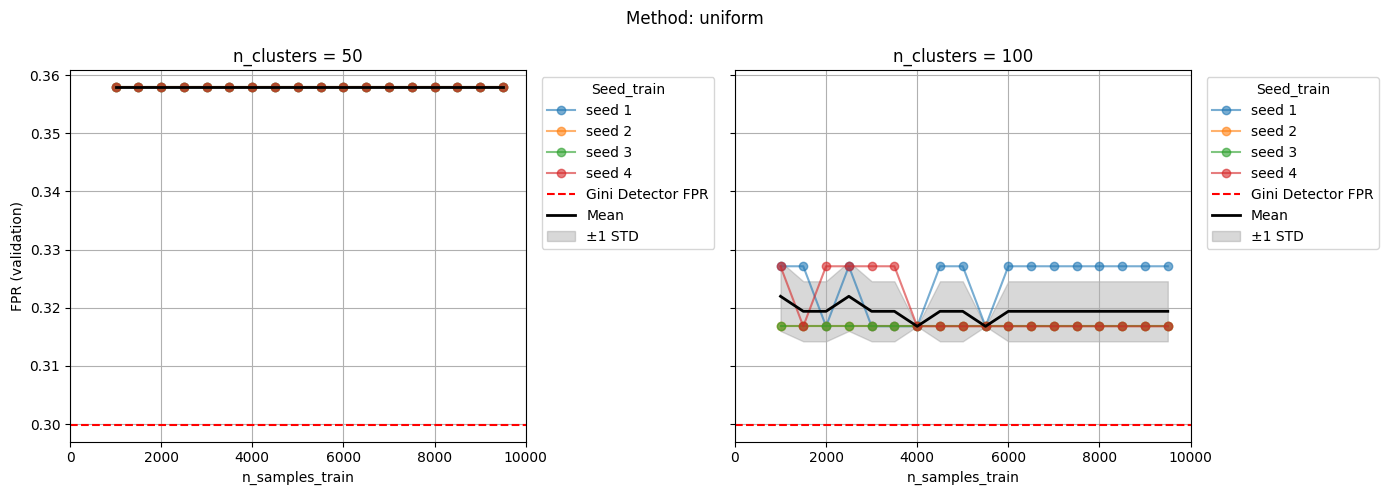

In [ ]:
plot_fpr_2(
    df,
    method="uniform",
    partionning_space="gini",
    cluster_values = [50,100],
    n_samples_train_inf=0,
    n_samples_train_sup=10000,
    seed_test=-1)

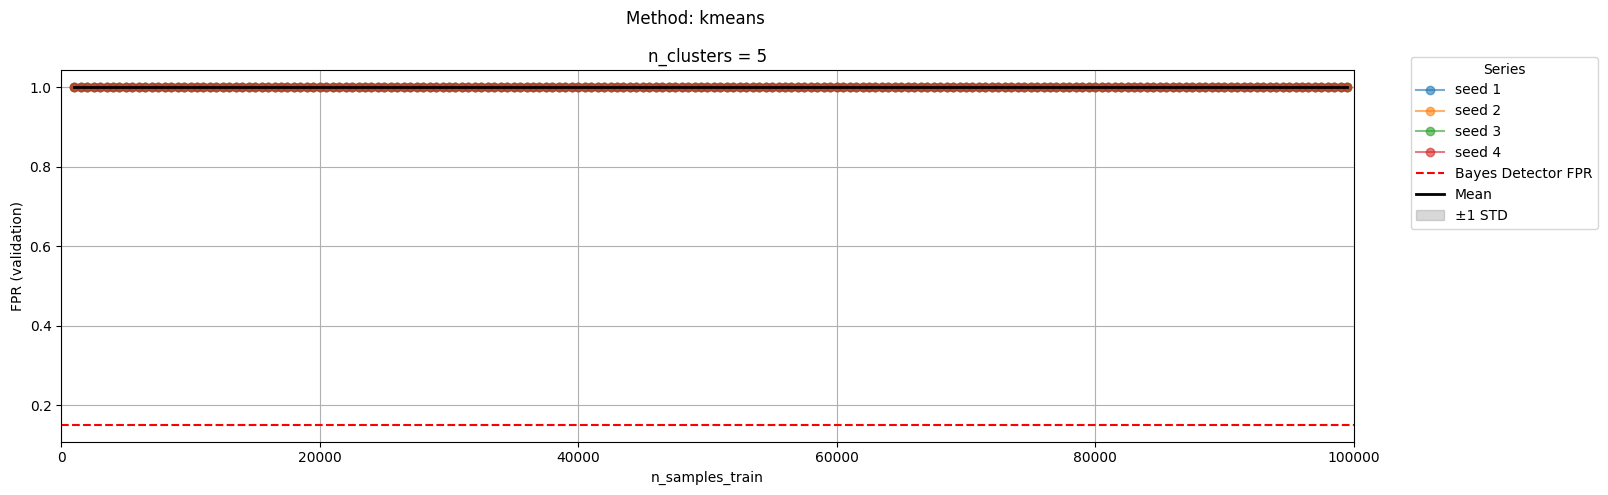

In [23]:
plot_fpr(df, seed_test=seed_test, cluster_values = [5],  method = "kmeans", n_samples_train_inf = 0, n_samples_train_sup = 100000)

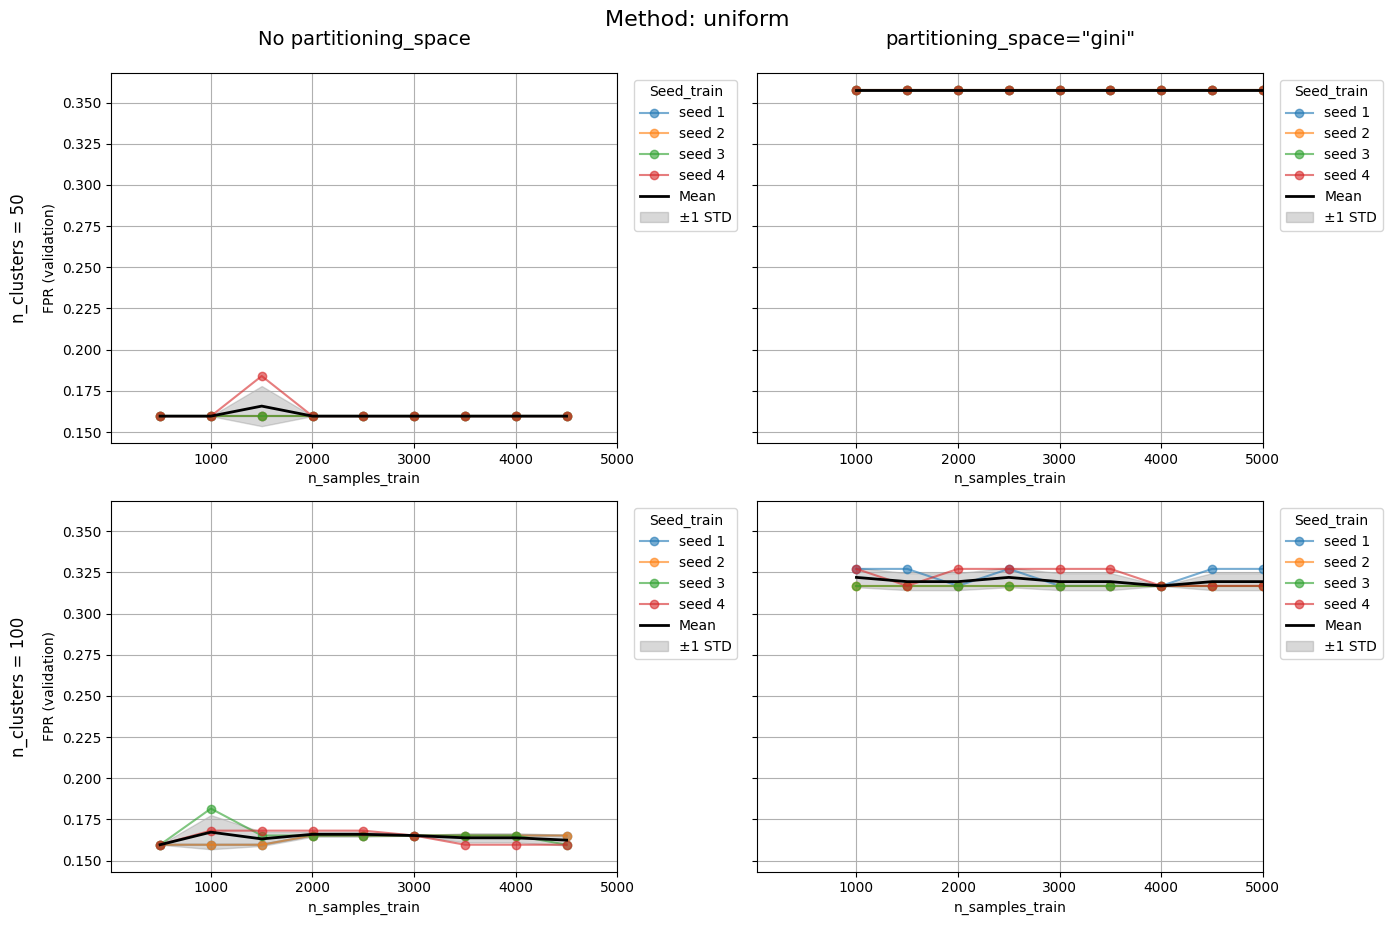

In [50]:
import numpy as np

def plot_fpr_partitioning(
    df,
    cluster_values,
    method="uniform",
    seed_test=None,
    n_samples_train_inf=None,
    n_samples_train_sup=None,
    ylim=None,
    x_interval=None
):
    """
    Plot FPR vs n_samples_train for two partitioning_space settings (NaN vs "gini")
    across multiple n_clusters, for a given method.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns ['n_clusters', 'n_samples_train', 'fpr_val',
        'seed_test', 'seed_train', 'method', 'partitioning_space'].
    cluster_values : list of int
        One row per cluster value.
    method : {"uniform", "kmeans"}
        Which sampling method to filter on.
    seed_test : int
        seed_test value to filter on.
    n_samples_train_inf : int
        Minimum n_samples_train to include.
    n_samples_train_sup : int
        Maximum n_samples_train to include.
    ylim : tuple or None
        Y-axis limits; e.g. (0,0.1).
    x_interval : int or None
        If provided, sets x‑axis ticks every `x_interval`.
    """
    # set up grid
    n = len(cluster_values)
    fig, axes = plt.subplots(n, 2, figsize=(14, 5*n), sharey=True)
    fig.suptitle(f"Method: {method}", fontsize=16, y=0.92)

    col_filters = [
        (df["partionning_space"].isna(),        "No partitioning_space"),
        (df["partionning_space"] == "gini",     'partitioning_space="gini"'),
    ]

    # column titles
    for j, (_, title) in enumerate(col_filters):
        axes[0, j].set_title(title, fontsize=14, pad=20)

    for i, k in enumerate(cluster_values):
        for j, (mask, _) in enumerate(col_filters):
            ax = axes[i, j]

            # filter for this cell
            df_c = df[
                (df["n_clusters"] == k) &
                (df["method"] == method) &
                mask &
                (df["seed_test"] == seed_test) &
                (df["n_samples_train"] >= n_samples_train_inf) &
                (df["n_samples_train"] <= n_samples_train_sup) &
                df["fpr_val"].notnull()
            ]

            # plot each seed_train
            for seed_train in sorted(df_c["seed_train"].unique()):
                df_s = df_c[df_c["seed_train"] == seed_train].sort_values("n_samples_train")
                ax.plot(
                    df_s["n_samples_train"],
                    df_s["fpr_val"],
                    marker="o",
                    linestyle="-",
                    alpha=0.6,
                    label=f"seed {seed_train}"
                )

            # mean ± std
            stats = (
                df_c
                .groupby("n_samples_train")["fpr_val"]
                .agg(["mean", "std"])
                .reset_index()
            )
            ax.plot(
                stats["n_samples_train"],
                stats["mean"],
                color="black",
                linewidth=2,
                label="Mean"
            )
            ax.fill_between(
                stats["n_samples_train"],
                stats["mean"] - stats["std"],
                stats["mean"] + stats["std"],
                color="gray",
                alpha=0.3,
                label="±1 STD"
            )

            # axes decor
            ax.set_xlabel("n_samples_train")
            if j == 0:
                ax.set_ylabel("FPR (validation)")
            ax.set_xlim(n_samples_train_inf, n_samples_train_sup)
            if ylim is not None:
                ax.set_ylim(ylim)
            ax.grid(True)

            # custom x-ticks
            if x_interval is not None:
                ticks = list(range(
                    n_samples_train_inf,
                    n_samples_train_sup + 1,
                    x_interval
                ))
                ax.set_xticks(ticks)

            # annotate row label on left
            if j == 0:
                ax.text(
                    -0.2, 0.5,
                    f"n_clusters = {k}",
                    transform=ax.transAxes,
                    rotation=90,
                    va="center",
                    fontsize=12
                )

            ax.legend(title="Seed_train", bbox_to_anchor=(1.02, 1), loc="upper left")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_fpr_partitioning(
    df=df,
    cluster_values=[50, 100],
    method="uniform",
    seed_test=-1,
    n_samples_train_inf=20,
    n_samples_train_sup=5000,
    # ylim=(0.15, 0.2)
)

**Best n_cluster**

BE carefull, the test seed are not equivalent

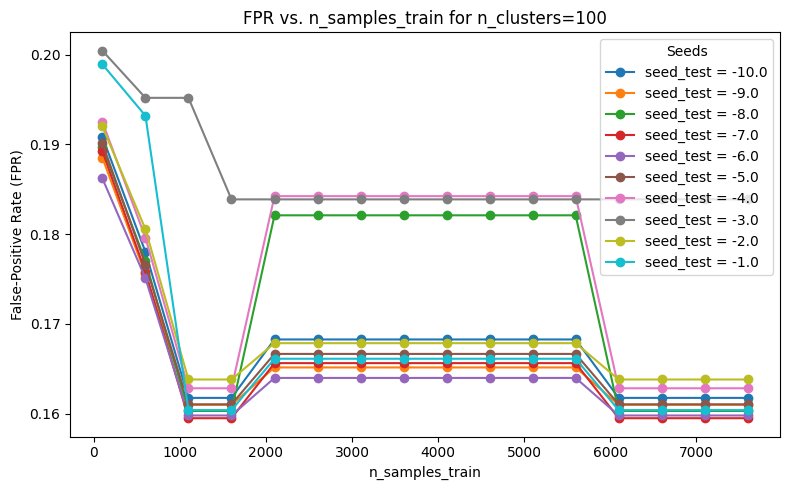

In [45]:
import matplotlib.pyplot as plt

# pick the one cluster-value you care about
cluster_value = 100

# filter down
n_samples_train_inf = 0
n_samples_train_sup = 1000000
# 1. filter out rows with n_samples_train < 1000


df_c = df[
   (df['n_clusters'] ==  cluster_value )& \
    (df['n_samples_train'] >= n_samples_train_inf) & \
    (df['n_samples_train'] <= n_samples_train_sup) & \
    df['fpr_train'].notnull() & \
    (df['seed_train'] == 1)
    ]

plt.figure(figsize=(8,5))
for seed_test in sorted(df_c['seed_test'].unique()):
    df_seed = (
        df_c[df_c['seed_test'] == seed_test]
        .sort_values('n_samples_train')
    )
    plt.plot(
        df_seed['n_samples_train'],
        df_seed['fpr_val'],
        marker='o',
        linestyle='-',
        label=f'seed_test = {seed_test}'
    )

plt.xlabel('n_samples_train')
plt.ylabel('False‑Positive Rate (FPR)')
plt.title(f'FPR vs. n_samples_train for n_clusters={cluster_value}')
plt.legend(title='Seeds')
plt.tight_layout()
plt.show()
